# Masinnägemise töötuba Padisel 2024
## Masinõppega emotsioonituvastus; koodivihik

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Seekord püüame pildi pealt tuvastada emotsioone. Treeningandmetena kasutame FER2013 andmestiku (https://www.kaggle.com/datasets/nicolejyt/facialexpressionrecognition). Andmestik koosneb 34034 näopildist ja 7 emotsioonist. Vt. Näide:
<img src="./fer_sample.png" alt="drawing" width="600"/>

Defineerime andmestiku ja loeme selle sisse:

In [ ]:
# Loome ise FER2013 andmestiku
class FER2013Dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        image = np.array([int(pixel) for pixel in row['pixels'].split()]).reshape(48, 48).astype(np.uint8)
        image = image[:, :, np.newaxis]
        label = int(row['emotion'])
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Laeme FER2013 andmestiku sisse
def load_fer2013_data(csv_file, batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = FER2013Dataset(csv_file=csv_file, transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader



In [ ]:
# faili asukoht 
csv_file = './fer2013/fer2013.csv'  # uuenda endale vastavalt
train_loader, test_loader = load_fer2013_data(csv_file)

Defineerime nüüd keerukama mudeli, mis kasutab ka **konvolutsioonilisi kihte** (e.g `Conv2d`). Sellised kihid on eriti head piltide jaoks.

In [5]:

# Defineerime mudeli emotsioonide tuvastamiseks
def create_emotion_recognition_model():
    model = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(128 * 6 * 6, 64),
        nn.ReLU(),
        nn.Linear(64, 7),
        nn.LogSoftmax(dim=1)
    )
    return model

# mudeli treenimise tsükkel
def train_model(model, train_loader, test_loader, num_epochs=10):
    criterion = nn.NLLLoss() #kaofunktsioon ehk õppimise headuse mõõt/suunis
    optimizer = optim.Adam(model.parameters(), lr=0.001) #õpialgoritm
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epohh {epoch+1}, Kadu: {total_loss / len(train_loader)}')

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Test täpsus: {accuracy}%')

    return model


model = create_emotion_recognition_model()
trained_model = train_model(model, train_loader, test_loader)



Epoch 1, Loss: 1.6106865759150752
Test Accuracy: 45.054332683198666%
Epoch 2, Loss: 1.3693542894648019
Test Accuracy: 50.94733909166899%
Epoch 3, Loss: 1.2588849549569638
Test Accuracy: 53.58038450821956%
Epoch 4, Loss: 1.1867961235726066
Test Accuracy: 55.558651434940096%
Epoch 5, Loss: 1.1310924756234897
Test Accuracy: 55.75369183616606%
Epoch 6, Loss: 1.0847123667498209
Test Accuracy: 57.42546670381722%
Epoch 7, Loss: 1.0436503134485342
Test Accuracy: 59.01365282808582%
Epoch 8, Loss: 1.005506747018521
Test Accuracy: 59.083310114237946%
Epoch 9, Loss: 0.9657538162838908
Test Accuracy: 59.0554471997771%
Epoch 10, Loss: 0.9372630630410328
Test Accuracy: 59.208693229311784%


Proovime mudelit test andmetega:

In [48]:
import random

def predict_random_test_image(model, test_loader):
    # Võtab juhuslikult ühe test andmepunkti ning ennustab selle numbrit
    test_images, test_labels = next(iter(test_loader))
    idx = random.randint(0, len(test_images) - 1)
    image, label = test_images[idx], test_labels[idx]
    
    # ennustab mudelist
    output = model(image.unsqueeze(0))  
    _, predicted = torch.max(output, 1)
    enesekindlus = np.round(np.e**torch.max(output,1)[0].item(),3)
    
    # Defineerime emotsioonid
    emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    # Kuvame tulemuse
    plt.imshow(image.squeeze(), cmap='gray')  
    plt.title(f'Õige emotsioon: {emotions[label]}, Ennustatud emotsioon: {emotions[predicted.item()]}, Enesekindlus: {enesekindlus}')
    plt.colorbar()
    plt.show()

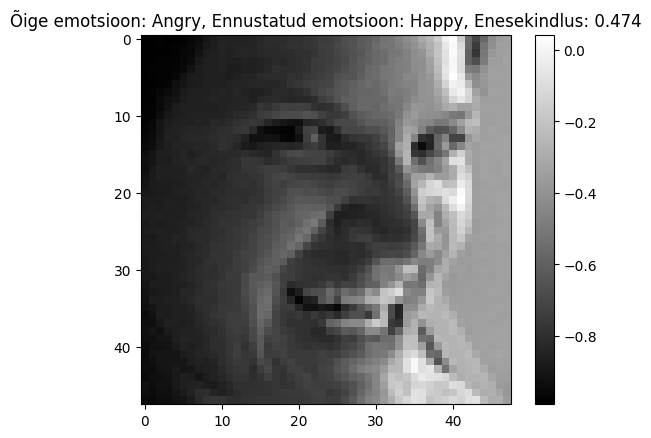

In [54]:
predict_random_test_image(model, test_loader)

Nüüd, loome veebikaamera rakenduse, mis lisab meie kaamerapildile meie emotsiooni.

vihjed:
1. kasutage `cv2` teeki ja dokumentatsiooni (https://docs.opencv.org/4.x/d7/dbd/group__imgproc.html)
2. ennustamine on juba ette antud funktsioonis `predict_random_test_image`
3. pildi peab muutma mustvalgeks ning suuruse ümber skaleerima
4. lisage ka mudeli enesekindlus 
5. isikupärastage veel lisaks kuidas soovite

In [ ]:
def start_webcam(model, ):
    cap = cv2.VideoCapture(0)
    emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # muuda pilt BGR värviskaalast mustvalgeks GRAY
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)#todo
        # reskaleeri pilt sobivaks mudeli jaoks
        resized = cv2.resize(gray, (48, 48))#todo
        tensor = torch.tensor(resized).unsqueeze(0).unsqueeze(0).float().to("cpu") / 255.0

        # Ennustus
        with torch.no_grad():
            outputs = model(tensor) #todo:ennustus
            _, predicted = torch.max(outputs.data, 1)
            predicted_emotion = emotions[predicted.item()]

        # Kuva tulemus
            #todo
        cv2.putText(frame,
                    predicted_emotion,
                    (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (0, 255, 0),
                    2,
                    cv2.LINE_AA)
        
        cv2.imshow('Emotsiooni tuvastus', frame)

        # Programm lõpeb, kui vajutame 'q' 
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Lõpetuseks vabastame kaamera
    cap.release()
    cv2.destroyAllWindows()


In [ ]:
start_webcam(model)

**BONUS** 

Kui tundub, et mudel ei saa meie enda numbritest aru, siis proovige mudelit paremaks saada lisades või eemaldades `create_emotion_recognition_model()` funktsiooni kihte, muutes aktivatsioone või regularisatsiooni või varieerides treeningu pikkust ehk epohhe. Vt. PyTorch dokumentatsiooni (https://pytorch.org/docs/stable/nn.html)